# Overview

The goal of this tutorial is to demonstrate the key components of a end-to-end data science/machine learning project. Note that the focus is to show the overall workflow not to build the best performing model.

The following shows the key steps:

- Load and split train/test data
- Exploratory Data Analysis (EDA)
- Data pre-processing and pipeline
- Model building, evaluation, tuning, and selection
- Feature importance analysis and feature selection
- Model persistence
- Web app development and deployment

TODO:

- Tree visualization
- Confusion matrix, ROC, AUC, Precision-Recall Trade-off
- Feature engineering
- AutoML

# Dataset

I choose the well-known Kaggle Titanic dataset due to its simplicity. 

For Google Colab, I use OpenML to get the dataset (the dataset is slightly different from the Kaggle version) so that there won't be separate data files to handle. 


<img width="947" alt="Screen Shot 2021-06-14 at 12 03 46 PM" src="https://user-images.githubusercontent.com/595772/121923350-d57b6b80-cd08-11eb-94d7-8c36f1193f20.png">


In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')  # change the default style

In [2]:
# read csv data into pandas dataframe
df = pd.read_csv('titanic.csv')

In [3]:
# basic shape, data type, null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# first 5 lines of data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Prepare the data by separating X and y
# dropping unimportant features, such as passenger id, name, ticket number and cabin number
# note that interesting features might be engieered from the dropped features above

# axis = 1 below means dropping by columns, 0 means by rows
X = df.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = df['Survived']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [6]:
# Split the data into a training set and a test set. 
# Any number for the random_state is fine, see 42: https://en.wikipedia.org/wiki/42_(number) 
# We choose to use 20% (test_size=0.2) of the data set as the test set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(712, 7)
(179, 7)


# Basic EDA
You can show basic descriptive statistics using pandas easily. 

In [7]:
# basic stats
X_train.describe(include='all')

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,712.000000,712,572.000000,712.000000,712.000000,712.000000,710
unique,NaN,2,NaN,NaN,NaN,NaN,3
top,NaN,male,NaN,NaN,NaN,NaN,S
freq,NaN,467,NaN,NaN,NaN,NaN,525
mean,2.330056,NaN,29.498846,0.553371,0.379213,32.586276,NaN
std,0.824584,NaN,14.500059,1.176404,0.791669,51.969529,NaN
min,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,2.000000,NaN,21.000000,0.000000,0.000000,7.925000,NaN
50%,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN
75%,3.000000,NaN,38.000000,1.000000,0.000000,30.500000,NaN


### Visual inspection is important
Simple descriptive statistics may not be enough and visual inspection of data is very important, i.e., check out Anscombe's quartet: https://en.wikipedia.org/wiki/Anscombe%27s_quartet

In [8]:
anscombe = pd.read_csv("anscombe.csv")
anscombe_grouped = anscombe.groupby('dataset')

# `key` contains the name of the grouped element 
# `group_df` is a normal dataframe containing only the data referring to the key
for key, group_df in anscombe.groupby('dataset'):
    print(group_df.describe()) 

               x          y
count  11.000000  11.000000
mean    9.000000   7.500909
std     3.316625   2.031568
min     4.000000   4.260000
25%     6.500000   6.315000
50%     9.000000   7.580000
75%    11.500000   8.570000
max    14.000000  10.840000
               x          y
count  11.000000  11.000000
mean    9.000000   7.500909
std     3.316625   2.031657
min     4.000000   3.100000
25%     6.500000   6.695000
50%     9.000000   8.140000
75%    11.500000   8.950000
max    14.000000   9.260000
               x          y
count  11.000000  11.000000
mean    9.000000   7.500000
std     3.316625   2.030424
min     4.000000   5.390000
25%     6.500000   6.250000
50%     9.000000   7.110000
75%    11.500000   7.980000
max    14.000000  12.740000
               x          y
count  11.000000  11.000000
mean    9.000000   7.500909
std     3.316625   2.030579
min     8.000000   5.250000
25%     8.000000   6.170000
50%     8.000000   7.040000
75%     8.000000   8.190000
max    19.000000  12

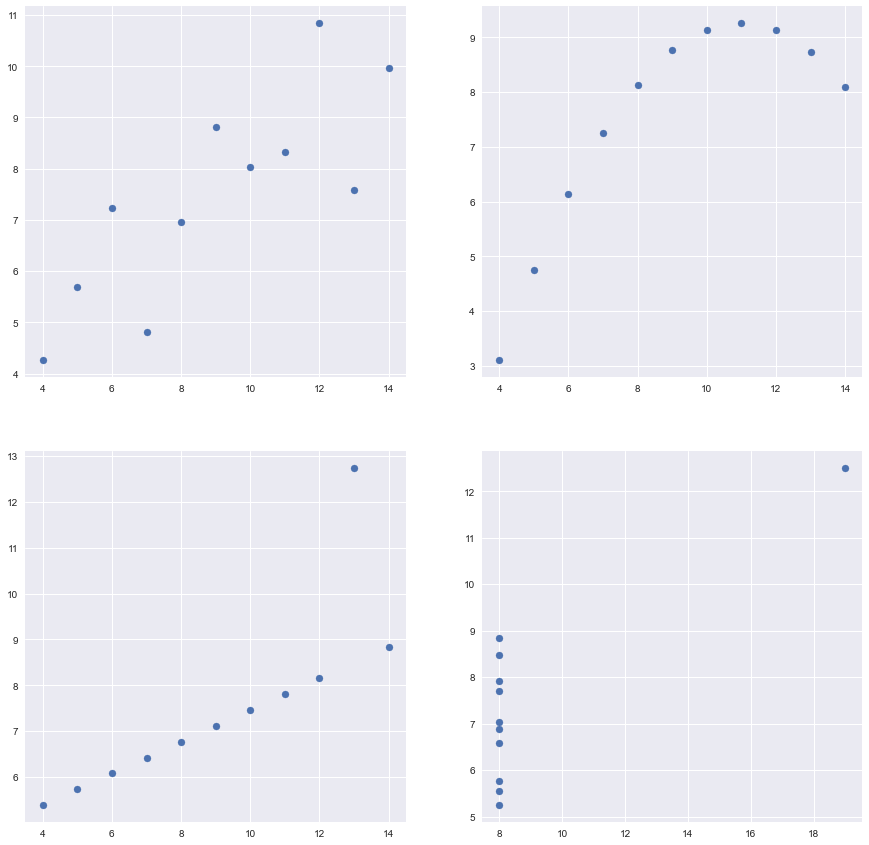

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0,0].scatter(anscombe[anscombe['dataset']=='I']['x'], anscombe[anscombe['dataset']=='I']['y'])
ax[0,1].scatter(anscombe[anscombe['dataset']=='II']['x'], anscombe[anscombe['dataset']=='II']['y'])
ax[1,0].scatter(anscombe[anscombe['dataset']=='III']['x'], anscombe[anscombe['dataset']=='III']['y'])
ax[1,1].scatter(anscombe[anscombe['dataset']=='IV']['x'], anscombe[anscombe['dataset']=='IV']['y'])

## Histogram
Use the histogram to check the followings:

- The distributions of the data 
- center and spread of the data
- skewness of the data
- presence of outliers

array([[<AxesSubplot:title={'center':'Pclass'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>]],
      dtype=object)

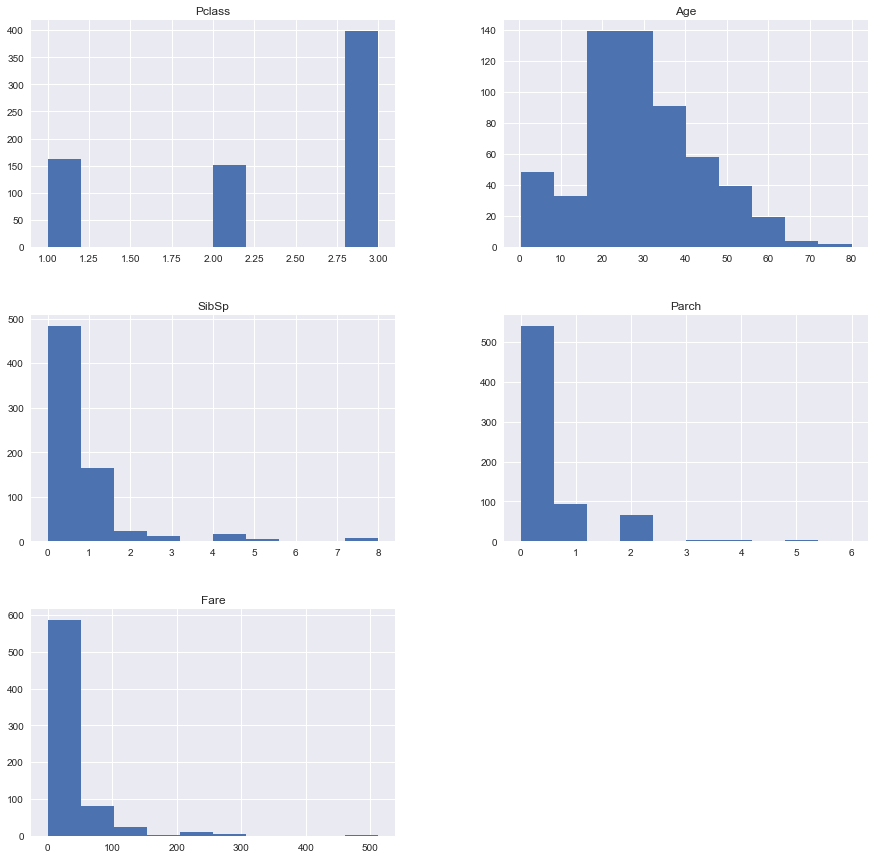

In [10]:
# histograms for all numerical features
X_train.hist(figsize=(15,15))

<AxesSubplot:>

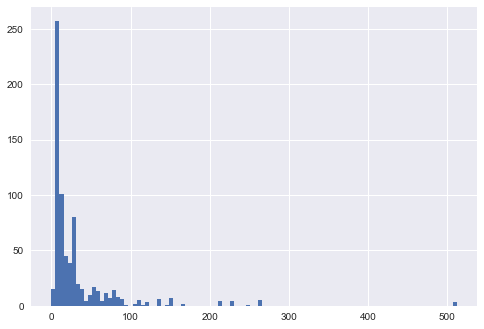

In [11]:
# key findings with potential processing
# long tail (skewed left): log transformation
# some outliers: outlier removal
X_train['Fare'].hist(bins=100)

## Box Plot

A boxplot displays the dataset based on a five-number summary:

- Median (Q2 / 50th Percentile) : the middle value of the dataset.

- First quartile (Q1 / 25th Percentile) : the middle value between the smallest number and the median of the dataset.

- Third quartile (Q3 / 75th Percentile) : the middle value between the largest number and the median of the dataset.

Interquartile Range (IQR) is the distance between the upper and lower quartile: IQR=Q3-Q1, 
IQR is used to determine outliers, which are points that are more than 1.5IQR from the median

- Minimum (NOT the smallest): the lowest data point excluding any outliers.

- Maximum (NOT the largest): the largest data point excluding any outliers.




### A box plot identifies the middle 50% of the data (the box), the median (the line in the box), and the outliers (the dots outside the max and min)

<AxesSubplot:>

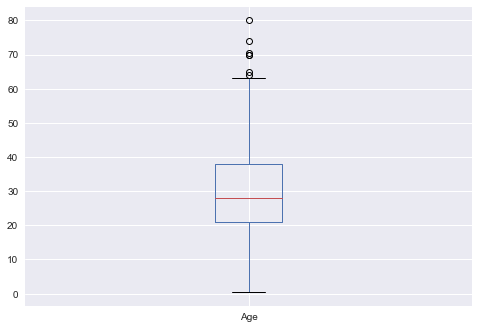

In [12]:
X_train['Age'].plot.box()

## Scatter Plot

Scatter plot is often used for **correlation analysis** between different features. Correlation coefficient is between -1 and 1, representing negative and positive correlations. 0 means there is no liner correlation. Correlation is said to be linear if the ratio of change is constant, otherwise is non-linear. 

Text(0, 0.5, 'Fare')

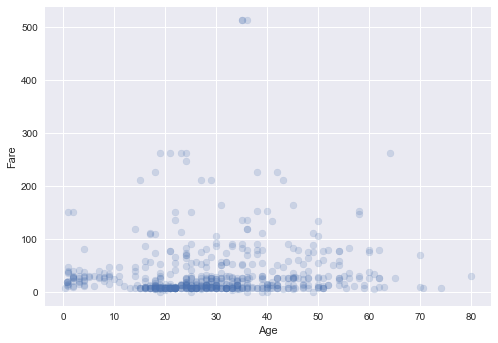

In [13]:
fig, ax = plt.subplots()
ax.scatter(x=X_train['Age'], y=X_train['Fare'], alpha=0.2) # alpha=0.2 specifies the opacity
ax.set_xlabel('Age')
ax.set_ylabel('Fare')

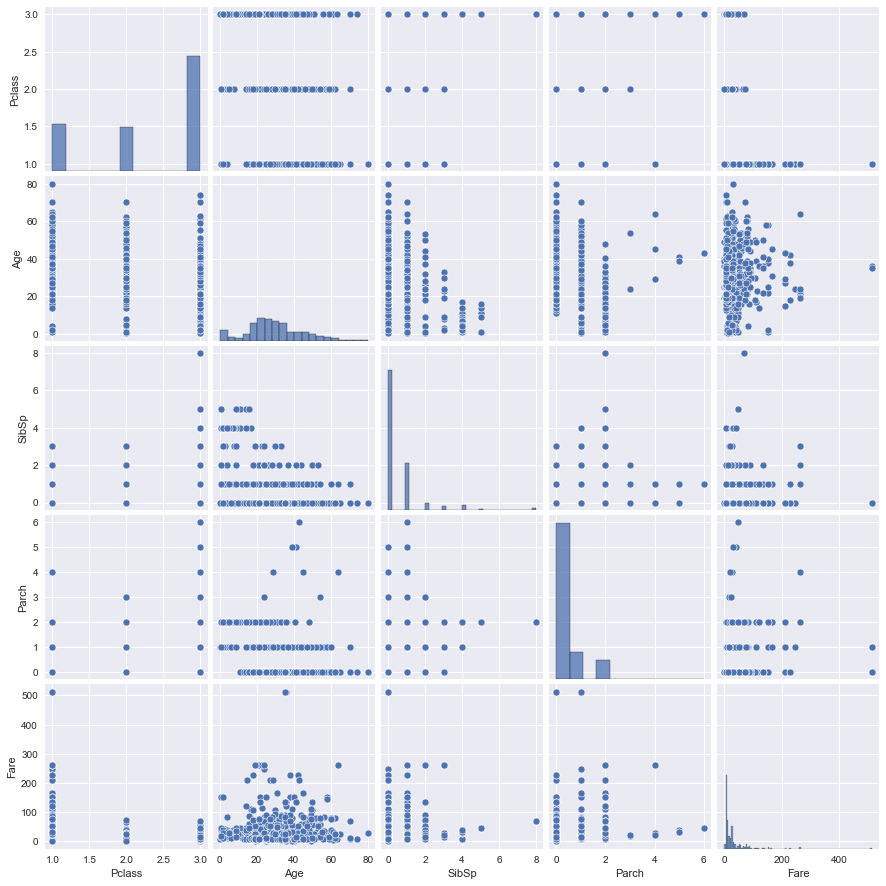

In [14]:
# pairplot example using seaborn
sns.pairplot(data=X_train)

## Data pre-processing
We will build a pipeline to do some of the following tasks:

- Missing data
- Feature scaling (important for certain model such as Gradient Descent based models)
- Categorical feature encoding
- Outlier removal
- Transformation
- Custom processing

In [15]:
# any missing values?
X_train.isnull().sum()

Pclass        0
Sex           0
Age         140
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [16]:
# We will train our decision tree classifier with the following features:
# Numerical Features: ['Age', 'SibSp', 'Fare', 'Parch']
# Categorical Features:['Sex', 'Embarked', 'Pclass'

num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Sex', 'Embarked', 'Pclass']

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create the preprocessing pipeline for numerical features
# There are two steps in this pipeline
# Pipeline(steps=[(name1, transform1), (name2, transform2), ...]) 
# NOTE the step names can be arbitrary

# Step 1 is what we discussed before - filling the missing values if any using mean
# Step 2 is feature scaling via standardization - making features look like normal-distributed 
# see sandardization: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
num_pipeline = Pipeline(
    steps=[
        ('num_imputer', SimpleImputer()),  # we will tune differet strategies later
        ('scaler', StandardScaler()),
        ]
)

# Create the preprocessing pipelines for the categorical features
# There are two steps in this pipeline:
# Step 1: filling the missing values if any using the most frequent value
# Step 2: one hot encoding

cat_pipeline = Pipeline(
    steps=[
        ('cat_imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder()),
    ]
)

# Assign features to the pipelines and Combine two pipelines to form the preprocessor
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, num_features),
        ('cat_pipeline', cat_pipeline, cat_features),
    ]
)

## Baseline prediction

It's always helpful to have some baseline predictions based on heuristics/rules so that you can benchmark your model performance. The following shows that female has much higher survival rate than male so that we can have a rule-based baseline to predict all female survivied and male died. For regression problem, an easy baseline could be using the training sample mean for all predictions.

In [18]:
# calculate the survival rates by gender
# female survival rate: 74.2%
# male survival rate: 18.9%
group_norm = df.groupby('Sex')['Survived'].value_counts(normalize=True)
group_norm

Sex     Survived
female  1           0.742038
        0           0.257962
male    0           0.811092
        1           0.188908
Name: Survived, dtype: float64

In [19]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
709,3,male,NaN,1,1,15.2458,C
439,2,male,31.0,0,0,10.5000,S
840,3,male,20.0,0,0,7.9250,S
720,2,female,6.0,0,1,33.0000,S
39,3,female,14.0,1,0,11.2417,C


In [20]:
# rule-based prediction
baseline_pred = X_test['Sex'].apply(lambda x: 0 if x == 'male' else 1)

In [21]:
from sklearn.metrics import accuracy_score
#print(f'Baseline Accuracy Score : {accuracy_score(y_test, baseline_pred)}')

## Model traning, tuning, evaluation and selection

Next, I attach three different models (Decision Tree, SVC, Random Forest) to the same pre-processing pipeline and tune the some parameters using GridSearch with cross validation. Then, we compare their performance and choose the best model to proceed. 

In [22]:
# Specify the model to use, which is DecisionTreeClassifier
# Make a full pipeline by combining preprocessor and the model
from sklearn.tree import DecisionTreeClassifier

pipeline_dt = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('clf_dt', DecisionTreeClassifier()),
    ]
)

In [23]:
# we show how to use GridSearch with K-fold cross validation (K=10) to fine tune the model
# we use the accuracy as the scoring metric with training score return_train_score=True
from sklearn.model_selection import GridSearchCV

# set up the values of hyperparameters you want to evaluate
# here you must use the step names as the prefix followed by two under_scores to sepecify the parameter names and the "full path" of the steps

# we are trying 2 different impputer strategies 
# 2x5 different decision tree models with different parameters
# in total we are trying 2x2x5 = 20 different combinations

param_grid_dt = [
    {
        'preprocessor__num_pipeline__num_imputer__strategy': ['mean', 'median'],
        'clf_dt__criterion': ['gini', 'entropy'], 
        'clf_dt__max_depth': [3, 4, 5, 6, 7],
    }
]

# set up the grid search 
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=10, scoring='accuracy')

In [24]:
# train the model using the full pipeline
grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat_pi

In [25]:
# check the best performing parameter combination
grid_search_dt.best_params_

{'clf_dt__criterion': 'entropy',
 'clf_dt__max_depth': 3,
 'preprocessor__num_pipeline__num_imputer__strategy': 'mean'}

In [26]:
# build-in CV results keys
sorted(grid_search_dt.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_clf_dt__criterion',
 'param_clf_dt__max_depth',
 'param_preprocessor__num_pipeline__num_imputer__strategy',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'split8_test_score',
 'split9_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [27]:
# test score for the 20 decision tree models
grid_search_dt.cv_results_['mean_test_score']

array([0.82443271, 0.82443271, 0.81177621, 0.81177621, 0.81318466,
       0.81320423, 0.8047144 , 0.80330595, 0.79493349, 0.79913928,
       0.82584116, 0.82584116, 0.82304382, 0.82304382, 0.80477308,
       0.80338419, 0.80899844, 0.80755086, 0.7948748 , 0.79489437])

In [28]:
# best decistion tree model test score
grid_search_dt.best_score_

0.8258411580594679

In [29]:
# try SVM classifer
from sklearn.svm import SVC

# SVC pipeline
pipeline_svc = Pipeline([
    ('preprocessor', preprocessor),
    ('clf_svc', SVC()),
])

# here we are trying three different kernel and three degree values for polynomail kernel
# in total 5 different combinations
param_grid_svc = [
    {
        'clf_svc__kernel': ['linear', 'poly', 'rbf'], 
        'clf_svc__degree': [3, 4, 5],  # only for poly kernel
    }
]

# set up the grid search 
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=10, scoring='accuracy')

In [30]:
# train the model using the full pipeline
grid_search_svc.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat_pi

In [31]:
# best test score
grid_search_svc.best_score_

0.8230829420970267

In [32]:
# try random forest classifer
from sklearn.ensemble import RandomForestClassifier

# rf pipeline
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf_rf', RandomForestClassifier()),
])

# here we are trying 2x3 different rf models
param_grid_rf = [
    {
        'clf_rf__criterion': ['gini', 'entropy'], 
        'clf_rf__n_estimators': [50, 100, 150],  
    }
]

# set up the grid search 
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=10, scoring='accuracy')

In [33]:
%%time
# train the model using the full pipeline
grid_search_rf.fit(X_train, y_train)

Wall time: 10 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat_pi

In [34]:
# best test score
print('best dt score is: ', grid_search_dt.best_score_)
print('best svc score is: ', grid_search_svc.best_score_)
print('best rf score is: ', grid_search_rf.best_score_)

best dt score is:  0.8258411580594679
best svc score is:  0.8230829420970267
best rf score is:  0.7963615023474179


In [35]:
# select the best model
# the best parameters are shown, note SimpleImputer() implies that mean strategry is used
clf_best = grid_search_dt.best_estimator_
clf_best

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
           

In [36]:
# final test on the testing set
# To predict on new data: simply calling the predict method 
# the full pipeline steps will be applied to the testing set followed by the prediction
y_pred = clf_best.predict(X_test)

# calculate accuracy, Note: y_test is the ground truth for the tesing set
# we have similiar score for the testing set as the cross validation score - good

#print(f'Accuracy Score : {accuracy_score(y_test, y_pred)}')

In [37]:
# our model is better than the base line - good
print(f'Baseline Accuracy Score : {accuracy_score(y_test, baseline_pred)}')
print(f'Our Best Accuracy Score : {accuracy_score(y_test, y_pred)}')

Baseline Accuracy Score : 0.7821229050279329
Our Best Accuracy Score : 0.7988826815642458


## Feature Importance

Given that we are using pipeline and one-hot encoding, the feature importance scores are not very straightforward to get. The following code shows how to get the feature importance scores from the decision tree model and create a plot.

In [38]:
clf_best.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num_pipeline',
                                  Pipeline(steps=[('num_imputer',
                                                   SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['Age', 'SibSp', 'Parch', 'Fare']),
                                 ('cat_pipeline',
                                  Pipeline(steps=[('cat_imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehot', OneHotEncoder())]),
                                  ['Sex', 'Embarked', 'Pclass'])]),
 'clf_dt': DecisionTreeClassifier(criterion='entropy', max_depth=3)}

In [39]:
clf_best.named_steps['preprocessor']

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat_pipeline',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['Sex', 'Embarked', 'Pclass'])])

In [40]:
i = clf_best['clf_dt'].feature_importances_
i

array([0.08110601, 0.05513595, 0.        , 0.0608736 , 0.54533576,
       0.        , 0.        , 0.        , 0.        , 0.05311821,
       0.        , 0.20443047])

In [41]:
clf_best['preprocessor'].transformers_

[('num_pipeline',
  Pipeline(steps=[('num_imputer', SimpleImputer()), ('scaler', StandardScaler())]),
  ['Age', 'SibSp', 'Parch', 'Fare']),
 ('cat_pipeline',
  Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
                  ('onehot', OneHotEncoder())]),
  ['Sex', 'Embarked', 'Pclass'])]

In [42]:
# get columnTransformer
clf_best[0] 

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat_pipeline',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['Sex', 'Embarked', 'Pclass'])])

In [43]:
clf_best[0].transformers_

[('num_pipeline',
  Pipeline(steps=[('num_imputer', SimpleImputer()), ('scaler', StandardScaler())]),
  ['Age', 'SibSp', 'Parch', 'Fare']),
 ('cat_pipeline',
  Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
                  ('onehot', OneHotEncoder())]),
  ['Sex', 'Embarked', 'Pclass'])]

In [44]:
num_original_feature_names = clf_best[0].transformers_[0][2]
num_original_feature_names

['Age', 'SibSp', 'Parch', 'Fare']

In [45]:
cat_original_feature_names = clf_best[0].transformers_[1][2]
cat_original_feature_names

['Sex', 'Embarked', 'Pclass']

In [46]:
cat_new_feature_names = list(clf_best[0].transformers_[1][1]['onehot'].get_feature_names(cat_original_feature_names))
cat_new_feature_names

['Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3']

In [47]:
feature_names = num_original_feature_names + cat_new_feature_names
feature_names

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3']

In [48]:
r = pd.DataFrame(i, index=feature_names, columns=['importance'])
r

,importance
Age,0.081106
SibSp,0.055136
Parch,0.000000
Fare,0.060874
Sex_female,0.545336
Sex_male,0.000000
Embarked_C,0.000000
Embarked_Q,0.000000
Embarked_S,0.000000
Pclass_1,0.053118


In [49]:
r.sort_values('importance', ascending=False)

,importance
Sex_female,0.545336
Pclass_3,0.204430
Age,0.081106
Fare,0.060874
SibSp,0.055136
Pclass_1,0.053118
Parch,0.000000
Sex_male,0.000000
Embarked_C,0.000000
Embarked_Q,0.000000


<AxesSubplot:>

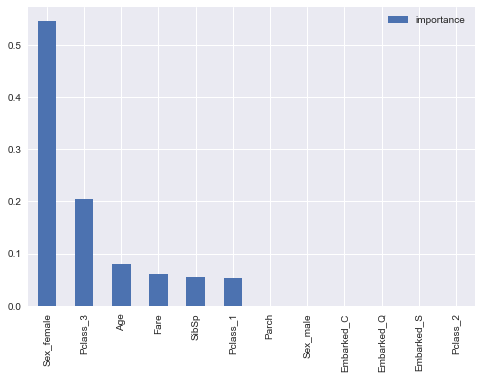

In [50]:
r.sort_values('importance', ascending=False).plot.bar()

In [51]:
# we remove the most important feature Sex and see how the model is affected
# result: accuracy drops from ~0.826 to ~0.716
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Embarked', 'Pclass']

# you must update preprocess and pipeline after changing the feature list
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, num_features),
        ('cat_pipeline', cat_pipeline, cat_features),
    ]
)

pipeline_dt = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('clf_dt', DecisionTreeClassifier()),
    ]
)

# update the grid search 
grid_search_dt_updated = GridSearchCV(pipeline_dt, param_grid_dt, cv=10, scoring='accuracy')

# train the model using the updated full pipeline
grid_search_dt_updated.fit(X_train, y_train)

print('best dt score is: ', grid_search_dt.best_score_)
print('best dt score after feature selection is: ', grid_search_dt_updated.best_score_)

best dt score is:  0.8258411580594679
best dt score after feature selection is:  0.716392801251956


In [52]:
# we remove unimportant features: Parch and Embarked and see the model is affected
# result: no difference with less features!!
num_features = ['Age', 'SibSp', 'Fare']
cat_features = ['Sex', 'Pclass']

# you must update preprocess and pipeline after changing the feature list
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, num_features),
        ('cat_pipeline', cat_pipeline, cat_features),
    ]
)

pipeline_dt = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('clf_dt', DecisionTreeClassifier()),
    ]
)

# update the grid search 
grid_search_dt_updated = GridSearchCV(pipeline_dt, param_grid_dt, cv=10, scoring='accuracy')

# train the model using the updated full pipeline
grid_search_dt_updated.fit(X_train, y_train)

print('best dt score is: ', grid_search_dt.best_score_)
print('best dt score after feature selection is: ', grid_search_dt_updated.best_score_)

best dt score is:  0.8258411580594679
best dt score after feature selection is:  0.8258411580594679


In [53]:
# reassign the best model to have only 5 features
clf_best = grid_search_dt_updated.best_estimator_

## Persist the Model
The following code shows how to save the trained model as a pickle file, which can be loaded in to make predictions.

In [54]:
# Save the model as a pickle file
import joblib
joblib.dump(clf_best, "clf-best.pickle")

['clf-best.pickle']

In [55]:
# Load the model from a pickle file
saved_tree_clf = joblib.load("clf-best.pickle")
saved_tree_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Fare']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Pclass'])]))

In [56]:
passenger1 = pd.DataFrame(
    {
        'Pclass': [3],
        'Sex': ['male'], 
        'Age': [23],
        'SibSp': [0],
        'Fare': [5.5],
    }
)
passenger1

,Pclass,Sex,Age,SibSp,Fare
0,3,male,23,0,5.5


In [57]:
passenger2 = pd.DataFrame(
    {
        'Pclass': [1],
        'Sex': ['female'], 
        'Age': [21],
        'SibSp': [0],
        'Parch': [0],
        'Fare': [80],
        'Embarked': ['S'],
    }
)
passenger2

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,female,21,0,0,80,S


In [59]:
# died
pred1 = saved_tree_clf.predict(passenger1)
pred1

ValueError: X has 5 features, but ColumnTransformer is expecting 7 features as input.

In [61]:
# survived
pred2 = saved_tree_clf.predict(passenger2)
pred2

array([1], dtype=int64)